# Hexagons
Refined version inspired by this video
https://www.youtube.com/watch?v=Yy7Q8IWNfHM&ab_channel=Mathologer
    Minute 34

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
cs = ['C0','C1','C2']
ec = 'k'
(x,y,z) = np.array((3**0.5/2+0.5j, -3**0.5/2+0.5j, 0-1j))

## Testing

First objective is to create a hexagonal grid. This can be grown from a unit hexagon at the origin by adding more hexagons around the edges. The centres of this first set of six hexagons themselves lie on a larger hexagon of radius $3^{0.5}$ tilted by 30 degrees. Then the next set of six hexagons have centres lying on the unit hexagon scaled up to radius 3, and so on.

- Coordinates of a unit radius hexagon centred on the origin of the complex plane, unitHex. 
- Now we just need to scale and optionally rotate to obtain all the of hexagons of centres.
- Then we just add the unitHex to each centre to find the coordinates of the grid

In [3]:
def hexN(n=0):
    """unitHex has n=0"""
    unitHex = np.exp(complex(0,np.pi/3))**np.arange(6) * (0-1j)
    if n==0:
        scaledHex = unitHex
    elif n%2==0:
        scaledHex = unitHex * 3 * n/2
    elif n%2==1:
        scaledHex = unitHex * 3**0.5 * (n+1)/2 * np.exp(complex(0,np.pi/6))
    return scaledHex

In [4]:
unitHex=hexN(0)

## Useful functions

In [5]:
def segments(c):
    """Returns three segments based centred on c"""
    aHex = c + unitHex
    segs =  [np.append(c,aHex[0:3])]
    segs += [np.append(c, aHex[2:5])]
    segs += [np.append(np.append(c,aHex[4:]),aHex[0])]
    return segs



Label the grid using triagonal coordinates, that are like upside down x,y,z axes in 3D, where x is NE, y is NW and z is south. (x,y,z) = (3^0.5/2+0.5j, -3^0.5/2+0.5j, 0-1j)
- For rows you add (1,-1,0) = 1 to move right
- Then middle row of the hexagon centres are on 
    - (0,0,0), (1,-1,0), (2,-2,0)... and their reflections in x=0
- Row above is on 
    - (1,0,-1), (2,-1,-1),(3,-2,-1)... and reflections in x=0
- Next row up is 
    - (1,1,-2), (2,0,-2), (3,-1,-2)... and reflections in x=0
- And for columns, you add (1,1,-2) = 3j to move up
- Middle columns is this 
    - (0,0,0), (1,1,-2), (2,2,-4), (3,3,-6)
- Next colum right is 
    - (1,0,-1), (2,1,-3), (2,1,-4)
- Next colum left is 
    - (0,0,-1), (1,2,-3), (2,3,-5)

## Initial attempt turned out to be very slow
Viewed as cube, heights must decrease montonically from back to front. Top row must fill from above, unless we decorate the hexagon with wall before starting. 
- Once we have an appropriate array of heights, we can convert to the coordinates of the graph using our standard graph axes, x and y, where -x=0.8660254 -0.5j and -y=-0.8660254 -0.5j

In [6]:
def getOrder(n):
    order = []
    for i in range(n):
        for j in range(i+1):
            order += [[i,j]]
            if i!=j:
                order +=[[j,i]]
    return order

def cropHeights(heights,upDown=-1):
    n = heights.shape[0]
    order = getOrder(n)
    heights[0,0] = min(heights[0,0],n)
    heights[n-1,n-1] = max(heights[n-1,n-1],0)
    if upDown==-1:
        for i,j in order:
            if i+2<=n:
                    heights[i+1,j] = heights[i:i+2,j].min()
            if j+2<=n:
                    heights[i,j+1] = heights[i,j:j+2].min()
    else:
        for i,j in order[::-1]:
            if i>0:
                    heights[i-1,j] = max(heights[i-1,j], heights[i,j])
                    if j>0:
                        heights[i-1,j-1] = max(heights[i-1,j-1],heights[i,j])
            if j>0:
                    heights[i,j-1] = max(heights[i,j-1], heights[i,j])
        
    return heights

In [7]:
from IPython.display import clear_output


def plotHexagon(heights, upDown=-1, cs = ['skyblue','C1','lightgrey'], ec='k'):

    n = heights.shape[0]
    heights = cropHeights(heights,upDown)
    order = getOrder(n)
    orderedHeights = [heights[i,j] for i,j in order]
    centres = np.array([-x*i-y*k for i,k in order])

    clear_output(wait=True)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xlim(-n,n)
    ax.set_ylim(-n,n)
    ax.axis('off')

    segs = segments(0)
    for i in range(n):
        for k in range(n):            
            sega = -i*x-k*z - segs[0]
            segb = -i*x-k*y - segs[1]
            segc = -i*y-k*z - segs[2]
            ax.fill(sega.real,sega.imag,c=cs[0],edgecolor=ec)
            ax.fill(segb.real,segb.imag,c=cs[1],edgecolor=ec)
            ax.fill(segc.real,segc.imag,c=cs[2],edgecolor=ec)

    bricks = np.arange(n)*1j
    for centre,height in zip(centres,orderedHeights):
        for brick in bricks[:height]:
#        for i, brick in enumerate(bricks):
#            if i<=height-1:
                centreB = centre+brick
                for c,seg in zip(cs,segments(centreB)):
                    #if flip:
                    #    seg =  centreB-(seg-centreB)
                    ax.fill(*[seg.real,seg.imag],c=c,edgecolor=ec)
    plt.show()
    return fig,ax


## Improve efficiency
OK that works but it is painfully slow for anything bigger than small hexagons, because it takes so long to print the whole figure every time. One option is to use matplotlib to plot a 3D pile of bricks, but this turns out to be pretty slow and it's really difficult to obtain the perfect hexagon.<br>


### Better solution
- For any particular configuration, locate and maintin lists of the bricks that can be flipped either up or down
- Flip one at random
- Update lists of the lists for the immediately neighbouring bricks

In [8]:
def findDown(heights):
    n = heights.shape[0]
    downList = [(n-1,n-1)] if heights[n-1,n-1]>0 else []
    # Cells that are bigger than the one below, grab those in the last column
    b = list(zip(*np.where(heights[:-1,:]>heights[1:,:])))
    downList += [(i,j) for i,j in b if j==n-1]
    # Cells that are bigger than the one right, grab those in the last row
    r = list(zip(*np.where(heights[:,:-1]>heights[:,1:])))
    downList += [(i,j) for i,j in r if i==n-1]
    # Cells that are bigger than the one below and right 
    br = list(zip(*np.where(heights[:-1,:-1]>heights[1:,1:])))
    downList += list(set(b).intersection(set(r),set(br)))
    return downList
    
def findUp(heights):
    n = heights.shape[0]
    upList = [(0,0)] if heights[0,0]<n else []
    # Cells that are smaller than the one above, grab those in the first column
    a = [(i+1,j) for i,j in zip(*np.where(heights[1:,:]<heights[:-1,:]))]
    upList += [(i,j) for i,j in a if j==0]
    # Cells that are bigger than the one right, grab those in the first row
    l = [(i,j+1) for i,j in zip(*np.where(heights[:,1:]<heights[:,:-1]))]
    upList += [(i,j) for i,j in l if i==0]
    # Cells that are bigger than the one below and right 
    al = [(i+1,j+1) for i,j in zip(*np.where(heights[1:,1:]<heights[:-1,:-1]))]
    upList += list(set(a).intersection(set(l),set(al)))
    return upList
    
    

### Final version

In [9]:
%matplotlib notebook


def changeHex(centreB, flip, fig, ax, cs = ['skyblue','C1','lightgrey']):
            for c,seg in zip(cs,segments(centreB)):
                if flip:
                    seg =  centreB-(seg-centreB)
                ax.fill(*[seg.real,seg.imag],c=c,edgecolor=ec)
            fig.set_figwidth(12) 
            fig.set_figheight(12) 
            fig.canvas.draw()
            #plt.draw()

            

def runHexagon2(iters=2,n=8,heights=np.array([]),plot=True):
    if heights.shape[0]==0:
        #heights = np.random.poisson(n//2,(n,n)).astype(int)
        heights = (np.arange(n,0,-1)[:,None]@np.arange(n,0,-1)[None,:]//n).astype(int)
    fig,ax = plotHexagon(heights)
    for its in tqdm(range(iters)):
        flip = np.random.choice([True,False])
        choice = findDown(heights) if flip else findUp(heights)
        nx = len(choice)
        if nx>0:
            select = choice[np.random.choice(nx)]
            i,k = select
            centreB = np.array([-x*i-y*k]) + (heights[select]-flip)*1j
            if plot:
                changeHex(centreB, flip, fig, ax)
            heights[select] += -1 if flip else 1
            #print(its,select,flip,heights[select])
            
    fig.canvas.draw()       
    return heights


In [36]:
%matplotlib notebook


<IPython.core.display.Javascript object>


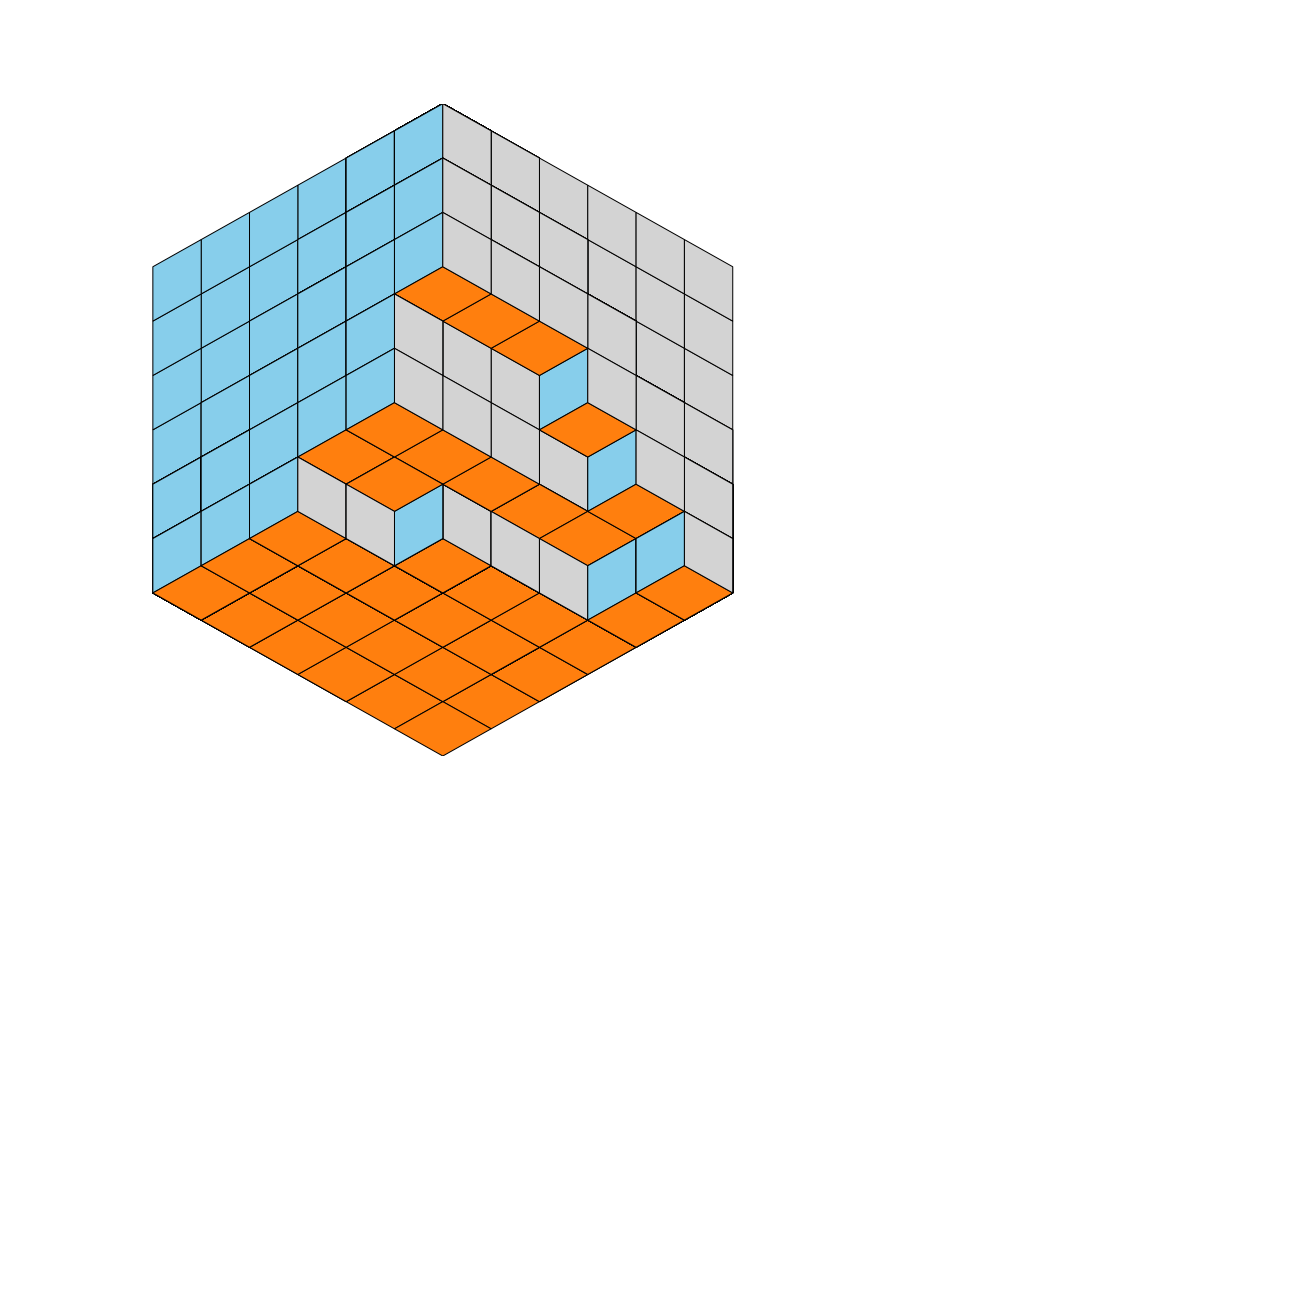

100%|██████████| 1000/1000 [05:39<00:00,  2.95it/s]


<IPython.core.display.Javascript object>


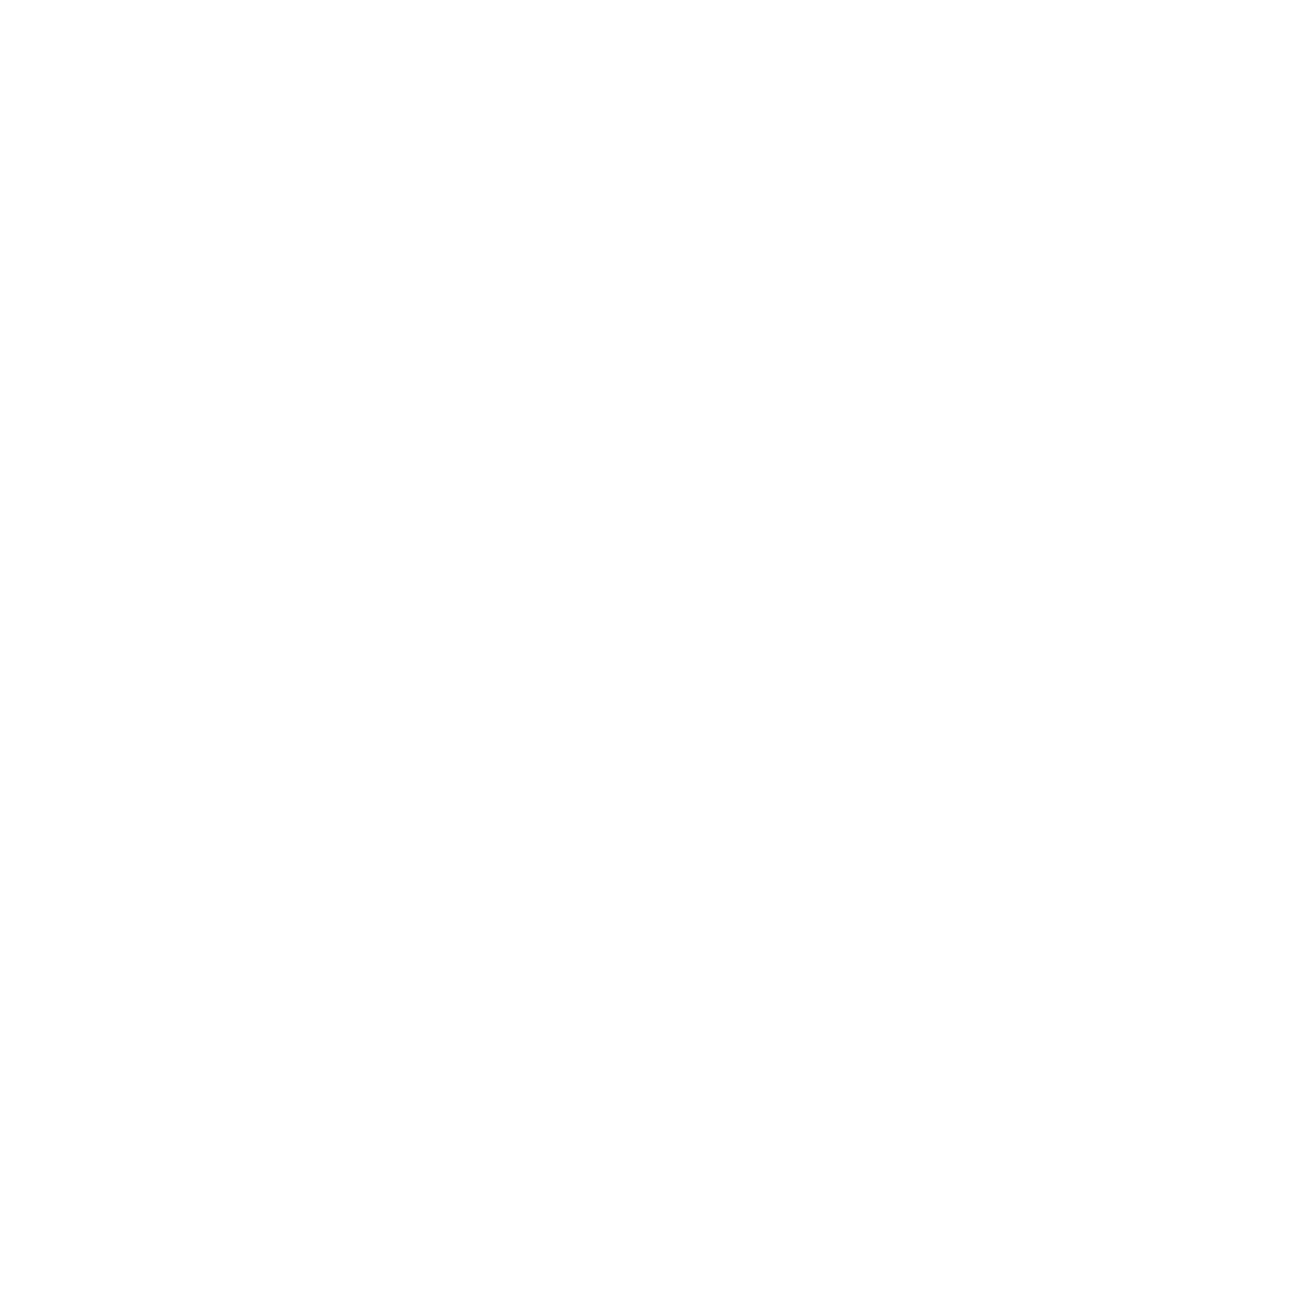

In [37]:
_ = runHexagon2(1000,6)

## Larger hexagons
Note that if you want to run more than about 10 iterations, you definitely need to set plot=False and just plot the result at the end.

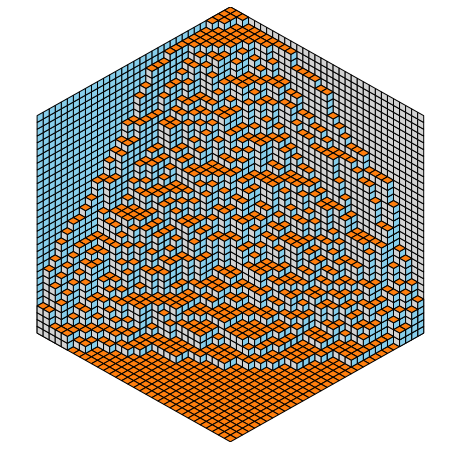

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [10]:
heights = np.load('Heights32.npy')
plotHexagon(heights)

<IPython.core.display.Javascript object>


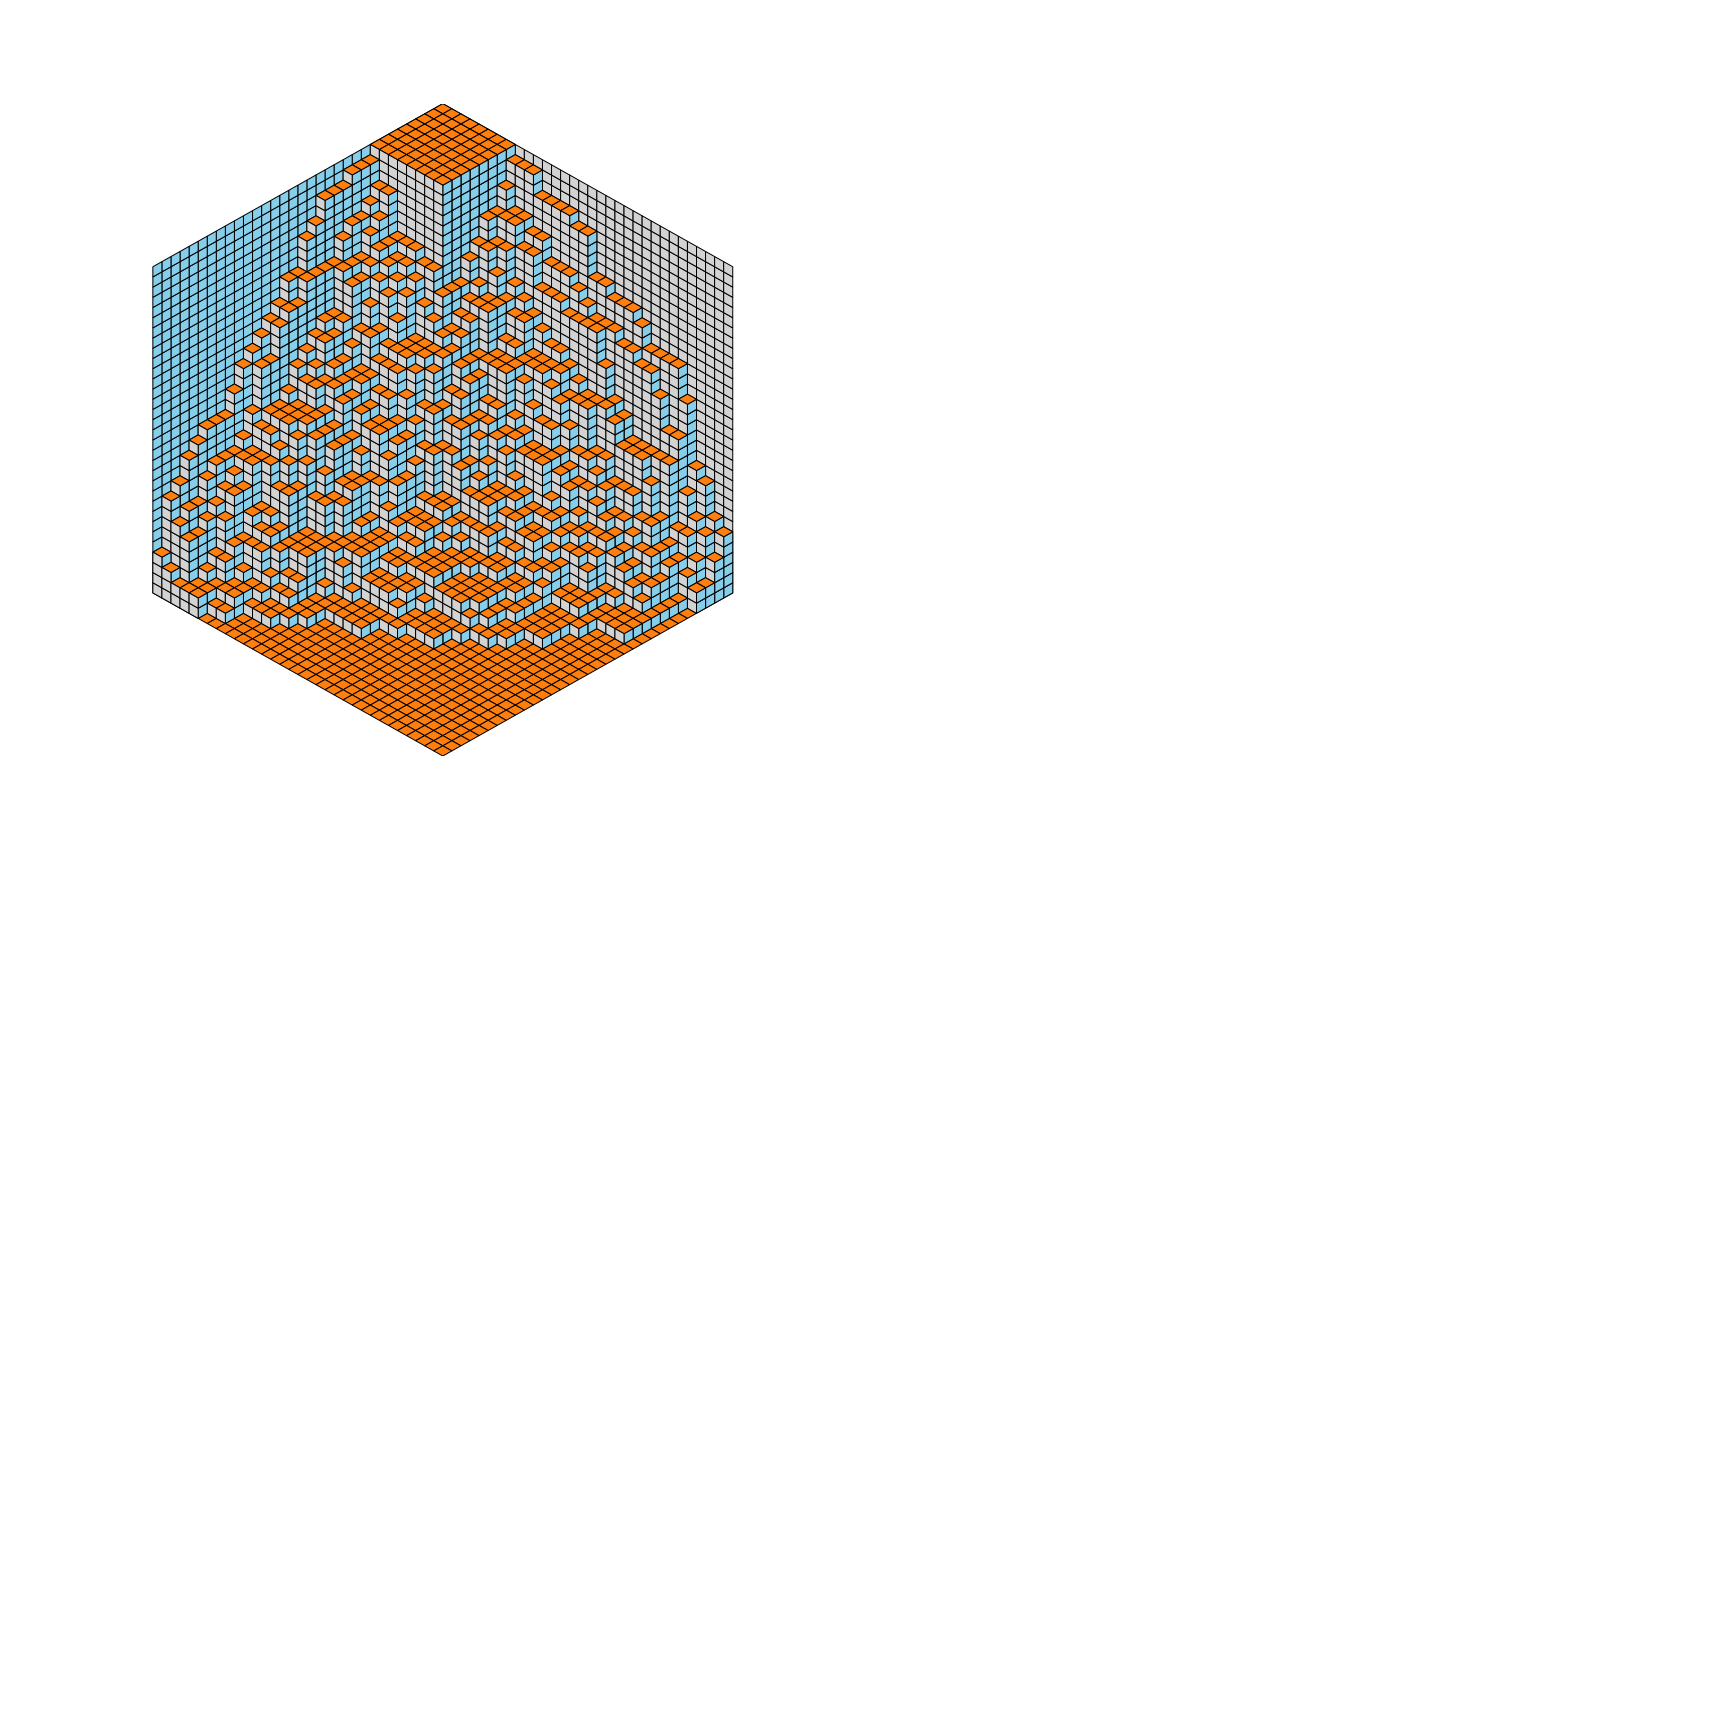

100%|██████████| 10/10 [00:39<00:00,  3.95s/it]


<IPython.core.display.Javascript object>

In [34]:

heights = np.load('Heights32.npy')
heights = runHexagon2(iters=10,n=32,heights=heights,plot=True)
np.save('Heights32',heights)